In [17]:
# Import Libraries and Setup
"""
# Machine Learning Exercise: Custom One-vs.-All Classification
# CIFAR Dataset Analysis with Logistic Regression

This notebook implements a custom One-vs-All (OvA) classifier from scratch and
compares it with the Softmax approach. The analysis is performed on the CIFAR-10
dataset to evaluate performance, training time, cost function, and more.
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, log_loss
import time
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
%matplotlib inline

In [18]:
# Helper Functions
# Function to load the data
def load_data(features_file, labels_file):
    """
    Load features and labels from the specified numpy files.

    Parameters:
    features_file -- path to the .npy file containing features
    labels_file -- path to the .npy file containing labels

    Returns:
    x1 -- numpy array of features
    y1 -- numpy array of labels
    """
    x1 = np.load(features_file)
    y1 = np.load(labels_file)
    return x1, y1

# Required testing function
def testmymodel(model, x_features, y_labels):
    """
    Tests the model on the given features and labels.

    Parameters:
    model -- trained model with predict method
    x_features -- numpy array of features
    y_labels -- numpy array of class labels

    Returns:
    accuracy -- accuracy score as a percentage
    """
    # Make predictions
    y_pred = model.predict(x_features)

    # Calculate accuracy
    accuracy = accuracy_score(y_labels, y_pred) * 100

    # Additional calculations (optional)
    print(f"Model Accuracy: {accuracy:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_labels, y_pred))

    # Calculate F1 score (mean)
    f1_mean = f1_score(y_labels, y_pred, average='macro')
    print(f"F1-mean Score: {f1_mean:.4f}")

    return accuracy

# Function to visualize performance metrics
def plot_performance_comparison(metrics_dict, title):
    """
    Creates a bar chart comparing performance metrics between models.

    Parameters:
    metrics_dict -- dictionary with model names as keys and metric values as values
    title -- title for the plot
    """
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(metrics_dict)), list(metrics_dict.values()), color=['skyblue', 'lightgreen', 'salmon'])
    plt.xticks(range(len(metrics_dict)), list(metrics_dict.keys()), rotation=0)
    plt.title(title)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.2f}', ha='center', va='bottom')

    plt.tight_layout()

In [19]:
# Custom One-vs-All Classifier Implementation
# Custom One-vs-All Classifier
class CustomOneVsAllClassifier:
    """
    Custom implementation of One-vs-All classifier using binary logistic regression.

    This class trains a separate binary classifier for each class and
    uses the model with highest confidence score for prediction.
    """

    def __init__(self, base_classifier=None, max_iter=1000, random_state=42):
        """
        Initialize the One-vs-All classifier.

        Parameters:
        base_classifier -- The base binary classifier to use (default: LogisticRegression)
        max_iter -- Maximum iterations for the base classifier
        random_state -- Random seed for reproducibility
        """
        self.max_iter = max_iter
        self.random_state = random_state
        self.classes_ = None
        self.classifiers = []

        if base_classifier is None:
            self.base_classifier = LogisticRegression
        else:
            self.base_classifier = base_classifier

    def fit(self, X, y):
        """
        Fit the One-vs-All classifier by training one classifier per class.

        Parameters:
        X -- Training data features
        y -- Training data labels

        Returns:
        self -- The fitted classifier
        """
        self.classes_ = np.unique(y)
        print(f"Training {len(self.classes_)} binary classifiers for classes: {self.classes_}")

        # Train one classifier for each class
        self.classifiers = []
        for i, class_label in enumerate(self.classes_):
            print(f"Training classifier for class {class_label} ({i+1}/{len(self.classes_)})")

            # Create binary labels (1 for current class, 0 for all others)
            y_binary = (y == class_label).astype(int)

            # Create and train the binary classifier
            clf = self.base_classifier(solver='liblinear', max_iter=self.max_iter,
                                       random_state=self.random_state)
            clf.fit(X, y_binary)

            # Store the trained classifier
            self.classifiers.append(clf)

        return self

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters:
        X -- Test data features

        Returns:
        y_pred -- Predicted class labels
        """
        # Get decision scores from all classifiers
        n_samples = X.shape[0]
        scores = np.zeros((n_samples, len(self.classes_)))

        for i, clf in enumerate(self.classifiers):
            # Get the probability of the positive class (probability of being in this class)
            scores[:, i] = clf.predict_proba(X)[:, 1]

        # Return class with highest score for each sample
        return self.classes_[np.argmax(scores, axis=1)]

    def predict_proba(self, X):
        """
        Predict class probabilities for samples in X.

        Parameters:
        X -- Test data features

        Returns:
        probas -- Class probabilities
        """
        # Get decision scores from all classifiers
        n_samples = X.shape[0]
        scores = np.zeros((n_samples, len(self.classes_)))

        for i, clf in enumerate(self.classifiers):
            # Get the probability of the positive class
            scores[:, i] = clf.predict_proba(X)[:, 1]

        # Normalize scores to make them sum to 1 (convert to probabilities)
        # Add small epsilon to avoid division by zero
        row_sums = scores.sum(axis=1) + 1e-15
        probas = scores / row_sums[:, np.newaxis]

        return probas


In [20]:
# Data Loading and Preparation
# Load the data
try:
    X, y = load_data('cifar10_features.npy', 'cifar10_labels.npy')
    print(f"Data loaded successfully. Features shape: {X.shape}, Labels shape: {y.shape}")
except FileNotFoundError:
    print("Files not found. Please adjust the file paths.")
    # Create sample data just for code demonstration
    X = np.random.rand(1000, 16)  # 1000 samples, 16 features as mentioned
    y = np.random.randint(0, 10, 1000)  # 10 classes (0-9)
    print("Using sample data for demonstration.")

# Split data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Training data: {X_train.shape}, Testing data: {X_test.shape}")

Data loaded successfully. Features shape: (50000, 16), Labels shape: (50000,)
Training data: (35000, 16), Testing data: (15000, 16)


In [21]:
# Method 1 - Softmax (Multinomial) Logistic Regression
print("\n==== Softmax (Multinomial) Logistic Regression ====")
start_time = time.time()
softmax_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
softmax_model.fit(X_train, y_train)
softmax_time = time.time() - start_time
print(f"Training time: {softmax_time:.2f} seconds")

# Test the softmax model
print("Evaluating Softmax model on test data...")
softmax_accuracy = testmymodel(softmax_model, X_test, y_test)


==== Softmax (Multinomial) Logistic Regression ====
Training time: 2.96 seconds
Evaluating Softmax model on test data...
Model Accuracy: 96.31%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1464
           1       0.99      0.99      0.99      1485
           2       0.95      0.95      0.95      1440
           3       0.92      0.93      0.93      1569
           4       0.97      0.96      0.97      1519
           5       0.94      0.94      0.94      1534
           6       0.98      0.97      0.98      1463
           7       0.97      0.97      0.97      1497
           8       0.98      0.98      0.98      1510
           9       0.98      0.98      0.98      1519

    accuracy                           0.96     15000
   macro avg       0.96      0.96      0.96     15000
weighted avg       0.96      0.96      0.96     15000

F1-mean Score: 0.9634


In [22]:
# Method 2 - Custom One-vs-All Logistic Regression
print("\n==== Custom One-vs-All Logistic Regression ====")
start_time = time.time()
custom_ovr_model = CustomOneVsAllClassifier(max_iter=1000, random_state=42)
custom_ovr_model.fit(X_train, y_train)
custom_ovr_time = time.time() - start_time
print(f"Training time: {custom_ovr_time:.2f} seconds")

# Test the custom one-vs.-all model
print("Evaluating Custom One-vs-All model on test data...")
custom_ovr_accuracy = testmymodel(custom_ovr_model, X_test, y_test)


==== Custom One-vs-All Logistic Regression ====
Training 10 binary classifiers for classes: [0 1 2 3 4 5 6 7 8 9]
Training classifier for class 0 (1/10)
Training classifier for class 1 (2/10)
Training classifier for class 2 (3/10)
Training classifier for class 3 (4/10)
Training classifier for class 4 (5/10)
Training classifier for class 5 (6/10)
Training classifier for class 6 (7/10)
Training classifier for class 7 (8/10)
Training classifier for class 8 (9/10)
Training classifier for class 9 (10/10)
Training time: 4.99 seconds
Evaluating Custom One-vs-All model on test data...
Model Accuracy: 96.08%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1464
           1       0.98      0.99      0.98      1485
           2       0.95      0.95      0.95      1440
           3       0.92      0.92      0.92      1569
           4       0.96      0.96      0.96      1519
           5       0.94      0.94      0.94

In [23]:
# Comparing Basic Metrics - Accuracy and Training Time
# Compare results
print("\n==== Comparison of Methods ====")
print(f"Softmax Accuracy: {softmax_accuracy:.2f}%, Training Time: {softmax_time:.2f} seconds")
print(f"Custom One-vs-All Accuracy: {custom_ovr_accuracy:.2f}%, Training Time: {custom_ovr_time:.2f} seconds")

# Accuracy comparison
accuracy_comparison = {
    'Softmax': softmax_accuracy,
    'Custom OvA': custom_ovr_accuracy
}
plot_performance_comparison(accuracy_comparison, 'Accuracy Comparison (%)')

# Training time comparison
time_comparison = {
    'Softmax': softmax_time,
    'Custom OvA': custom_ovr_time
}
plot_performance_comparison(time_comparison, 'Training Time Comparison (seconds)')


==== Comparison of Methods ====
Softmax Accuracy: 96.31%, Training Time: 2.96 seconds
Custom One-vs-All Accuracy: 96.08%, Training Time: 4.99 seconds


In [24]:
# Cost Function and F1-Score Analysis
# Calculate cost function (log loss) for both methods
print("\n==== Cost Function Analysis ====")
print("Calculating log loss (cost function) for both models...")

# For softmax
y_proba_softmax = softmax_model.predict_proba(X_test)
softmax_cost = log_loss(y_test, y_proba_softmax)
print(f"Softmax Cost Function (Log Loss): {softmax_cost:.4f}")

# For custom one-vs-all
y_proba_custom_ovr = custom_ovr_model.predict_proba(X_test)
custom_ovr_cost = log_loss(y_test, y_proba_custom_ovr)
print(f"Custom One-vs-All Cost Function (Log Loss): {custom_ovr_cost:.4f}")

# Calculate F1-mean for both methods
print("\n==== F1-Score Analysis ====")
print("Calculating F1-mean scores for both models...")
f1_mean_softmax = f1_score(y_test, softmax_model.predict(X_test), average='macro')
f1_mean_custom_ovr = f1_score(y_test, custom_ovr_model.predict(X_test), average='macro')
print(f"F1-mean Softmax: {f1_mean_softmax:.4f}")
print(f"F1-mean Custom One-vs-All: {f1_mean_custom_ovr:.4f}")

# Log loss comparison
loss_comparison = {
    'Softmax': softmax_cost,
    'Custom OvA': custom_ovr_cost
}
plot_performance_comparison(loss_comparison, 'Log Loss Comparison')

# F1-score comparison
f1_comparison = {
    'Softmax': f1_mean_softmax,
    'Custom OvA': f1_mean_custom_ovr
}
plot_performance_comparison(f1_comparison, 'F1-mean Score Comparison')


==== Cost Function Analysis ====
Calculating log loss (cost function) for both models...
Softmax Cost Function (Log Loss): 0.1077
Custom One-vs-All Cost Function (Log Loss): 0.1348

==== F1-Score Analysis ====
Calculating F1-mean scores for both models...
F1-mean Softmax: 0.9634
F1-mean Custom One-vs-All: 0.9610


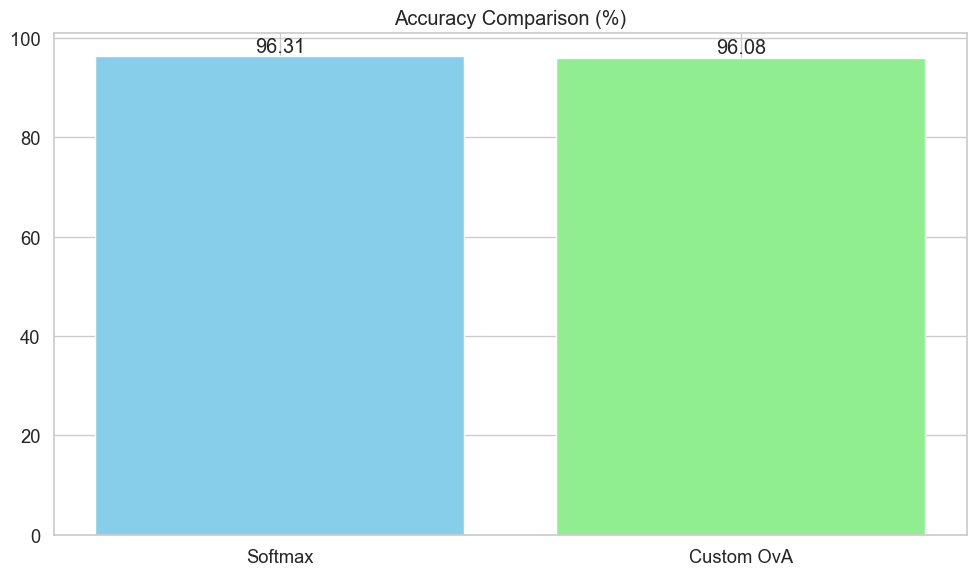

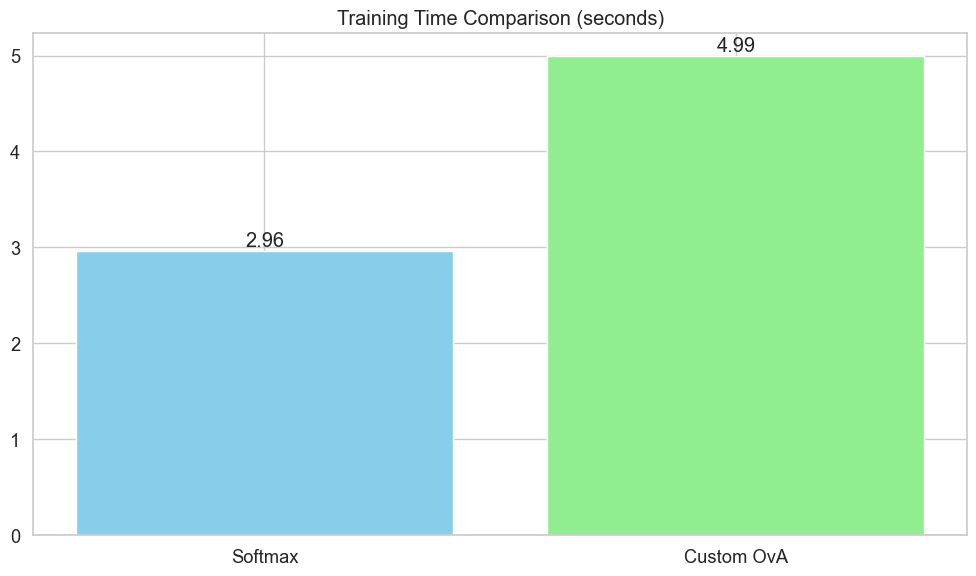

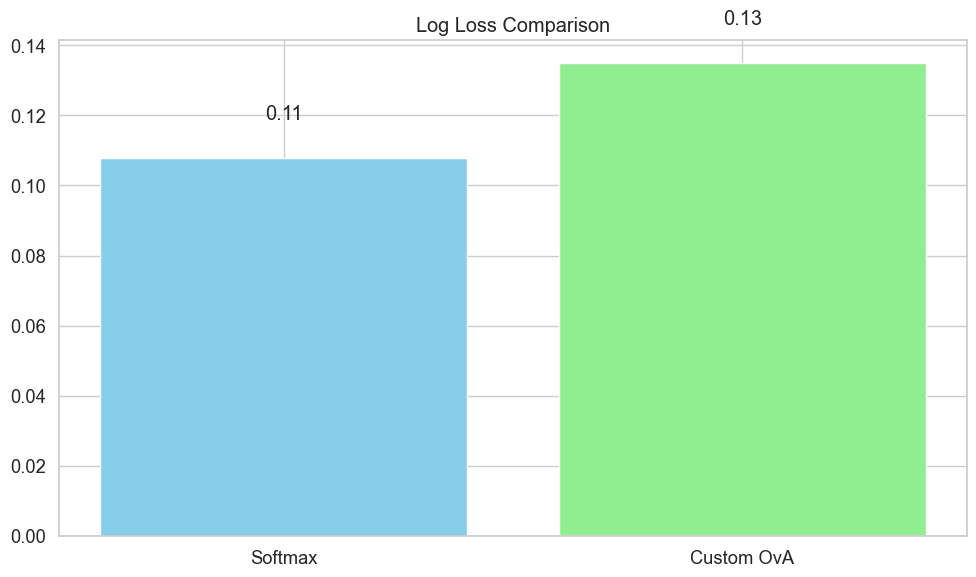

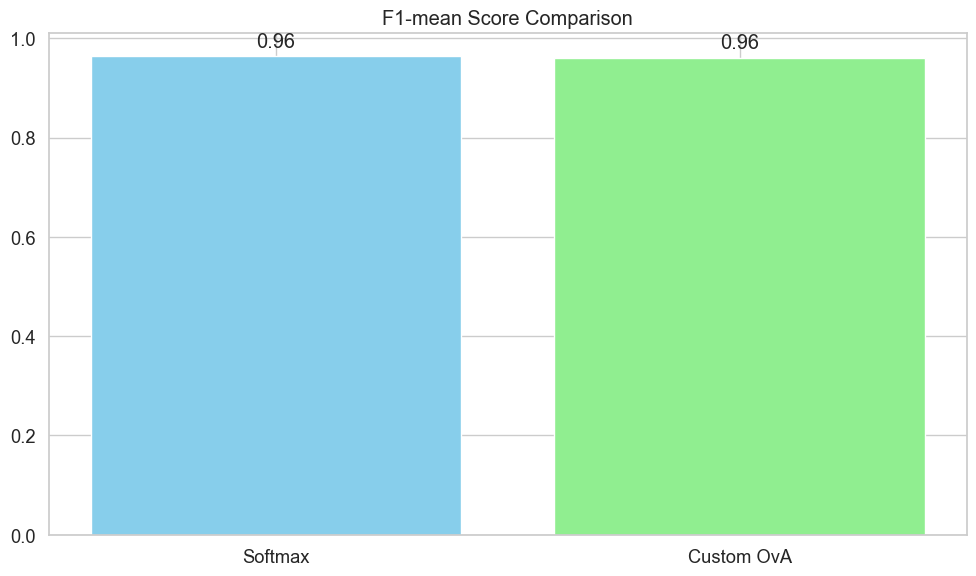

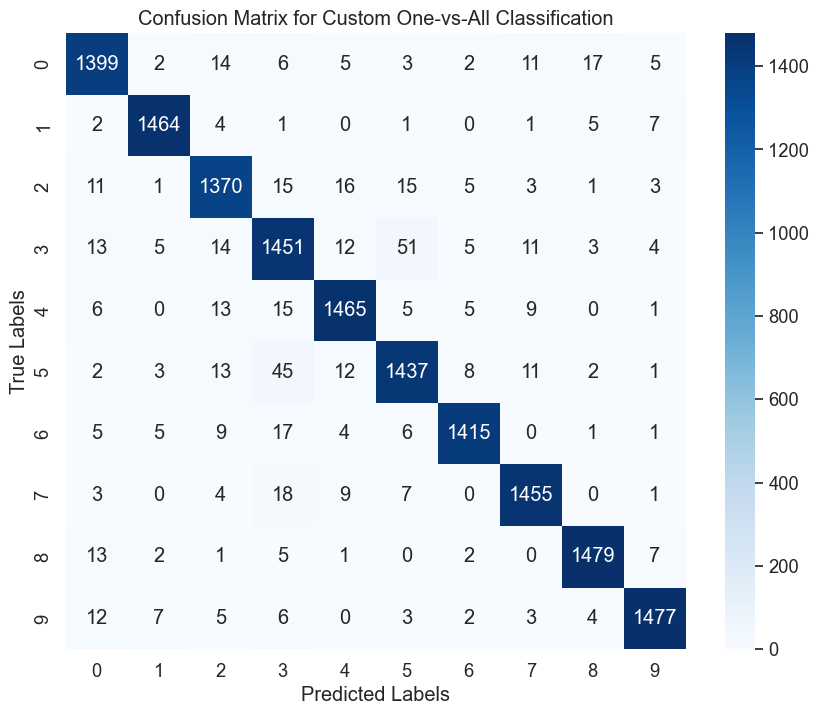


Most confused classes: 3 and 5
Number of confusions: 51 from class 3 predicted as class 5
Number of confusions: 45 from class 5 predicted as class 3


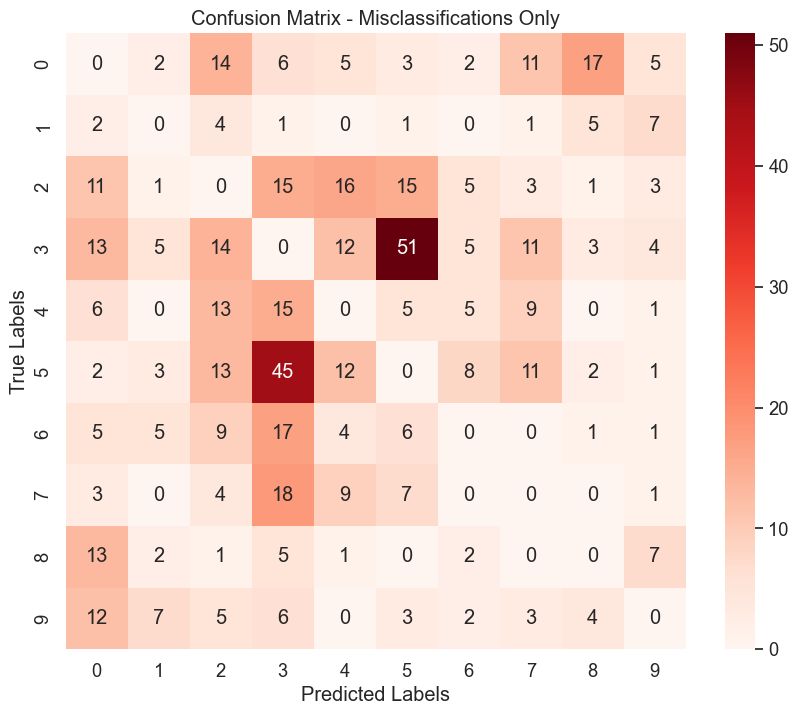

In [25]:
# Confusion Matrix Analysis
# Analyze confusion matrix for custom one-vs.-all
y_pred_custom_ovr = custom_ovr_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_custom_ovr)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Custom One-vs-All Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Find the most confused classes
np.fill_diagonal(conf_matrix, 0)  # Set diagonal to 0 to ignore correct classifications
most_confused_idx = np.unravel_index(np.argmax(conf_matrix), conf_matrix.shape)
class1, class2 = most_confused_idx
print(f"\nMost confused classes: {class1} and {class2}")
print(f"Number of confusions: {conf_matrix[class1, class2]} from class {class1} predicted as class {class2}")
print(f"Number of confusions: {conf_matrix[class2, class1]} from class {class2} predicted as class {class1}")

# Create a heatmap showing only off-diagonal (misclassification) values
plt.figure(figsize=(10, 8))
conf_matrix_off_diag = conf_matrix.copy()  # Already has diagonal set to 0
sns.heatmap(conf_matrix_off_diag, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - Misclassifications Only')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [26]:
# Specialized Binary Classifier for Most Confused Classes
# Create a specific model for the most confused pair of classes
print("\n==== Creating Specific Model for Most Confused Classes ====")
print(f"Developing a specialized binary classifier for classes {class1} and {class2}...")

# Filter data to only include the two most confused classes
mask_train = np.isin(y_train, [class1, class2])
X_binary_train = X_train[mask_train]
y_binary_train = y_train[mask_train]
# Convert labels to binary (0 and 1)
y_binary_train = (y_binary_train == class2).astype(int)

mask_test = np.isin(y_test, [class1, class2])
X_binary_test = X_test[mask_test]
y_binary_test = y_test[mask_test]
y_binary_test_original = y_binary_test.copy()  # Keep original labels for reporting
y_binary_test = (y_binary_test == class2).astype(int)

# Train a binary classifier
binary_model = LogisticRegression(random_state=42)
binary_model.fit(X_binary_train, y_binary_train)

# Evaluate the binary classifier
binary_accuracy = accuracy_score(y_binary_test, binary_model.predict(X_binary_test)) * 100
print(f"Binary Classifier Accuracy: {binary_accuracy:.2f}%")


==== Creating Specific Model for Most Confused Classes ====
Developing a specialized binary classifier for classes 3 and 5...
Binary Classifier Accuracy: 96.23%



==== Implementing Hybrid Approach ====
Combining Custom One-vs-All model with specialized binary classifier...
Original Custom One-vs-All Accuracy: 96.08%
Hybrid Approach Accuracy: 96.07%
Improvement: -0.01%


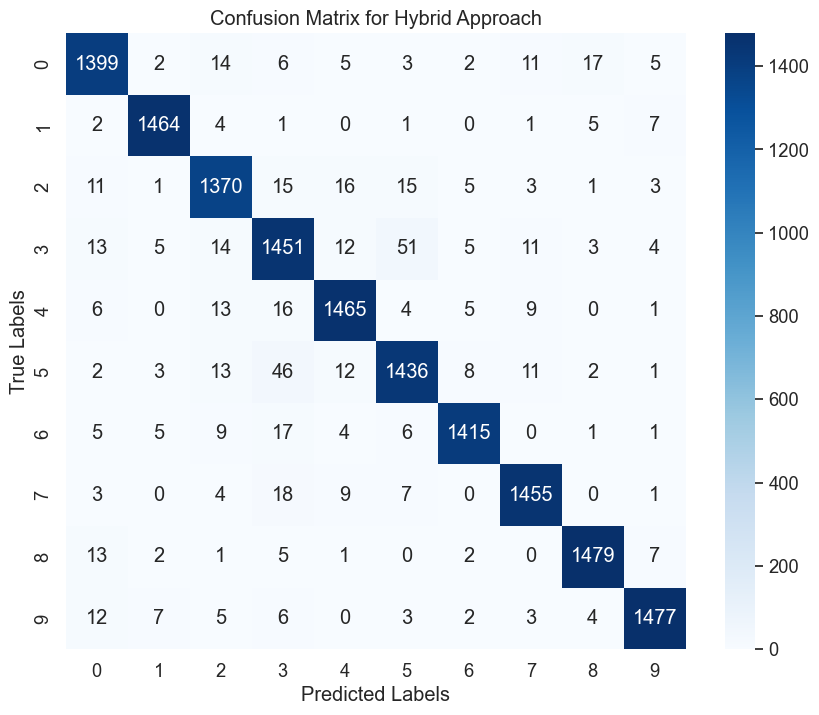

In [27]:
# Hybrid Approach Implementation and Evaluation
# Create a hybrid approach
print("\n==== Implementing Hybrid Approach ====")
print("Combining Custom One-vs-All model with specialized binary classifier...")
# For instances predicted as either class1 or class2 by the original model,
# use the binary model to make the final prediction
y_hybrid_pred = y_pred_custom_ovr.copy()

# Find instances where the original model predicted either class1 or class2
mask_hybrid = np.isin(y_hybrid_pred, [class1, class2])
binary_indices = np.where(mask_hybrid)[0]

if len(binary_indices) > 0:
    # For these instances, use the binary model
    binary_preds = binary_model.predict(X_test[binary_indices])
    # Convert binary predictions back to original class labels
    y_hybrid_pred[binary_indices] = np.where(binary_preds == 0, class1, class2)

# Calculate and compare the hybrid approach accuracy
hybrid_accuracy = accuracy_score(y_test, y_hybrid_pred) * 100
print(f"Original Custom One-vs-All Accuracy: {custom_ovr_accuracy:.2f}%")
print(f"Hybrid Approach Accuracy: {hybrid_accuracy:.2f}%")

# Compute improvement
improvement = hybrid_accuracy - custom_ovr_accuracy
print(f"Improvement: {improvement:.2f}%")

# Show confusion matrix for the hybrid approach
hybrid_conf_matrix = confusion_matrix(y_test, y_hybrid_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(hybrid_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Hybrid Approach')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Confusion between classes 3 and 5 in original model: 96
Confusion between classes 3 and 5 in hybrid model: 97
Reduction in confusion: -1 instances (-1.04%)


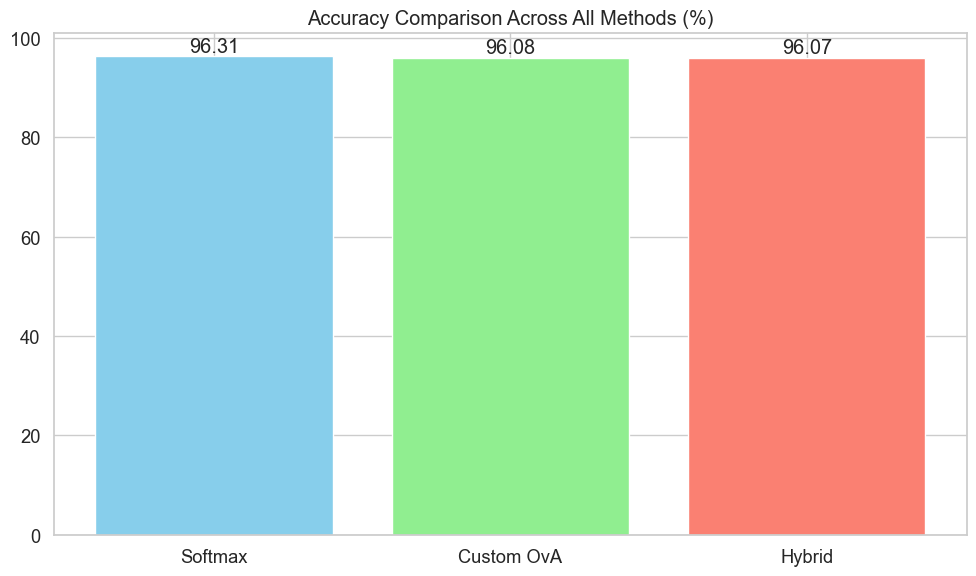

<Figure size 1000x600 with 0 Axes>

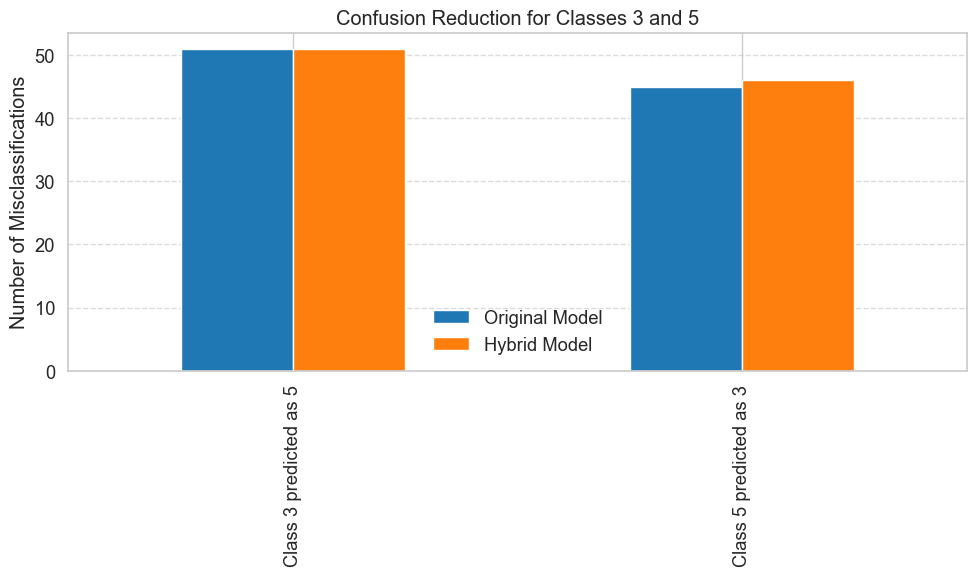

In [28]:
# Final Comparisons and Visualization
# Compare all three approaches
all_models_accuracy = {
    'Softmax': softmax_accuracy,
    'Custom OvA': custom_ovr_accuracy,
    'Hybrid': hybrid_accuracy
}
plot_performance_comparison(all_models_accuracy, 'Accuracy Comparison Across All Methods (%)')

# Analyze specific improvements in the confusion of the most confused classes
original_confusion = conf_matrix[class1, class2] + conf_matrix[class2, class1]
hybrid_confusion = hybrid_conf_matrix[class1, class2] + hybrid_conf_matrix[class2, class1]
confusion_reduction = original_confusion - hybrid_confusion

print(f"\nConfusion between classes {class1} and {class2} in original model: {original_confusion}")
print(f"Confusion between classes {class1} and {class2} in hybrid model: {hybrid_confusion}")
print(f"Reduction in confusion: {confusion_reduction} instances ({confusion_reduction/original_confusion*100:.2f}%)")

# Create a dataframe to compare before/after confusion matrix values
confusion_df = pd.DataFrame({
    'Original Model': [conf_matrix[class1, class2], conf_matrix[class2, class1]],
    'Hybrid Model': [hybrid_conf_matrix[class1, class2], hybrid_conf_matrix[class2, class1]]
}, index=[f'Class {class1} predicted as {class2}', f'Class {class2} predicted as {class1}'])

# Plot the comparison
plt.figure(figsize=(10, 6))
confusion_df.plot(kind='bar', figsize=(10, 6))
plt.title(f'Confusion Reduction for Classes {class1} and {class2}')
plt.ylabel('Number of Misclassifications')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
# Conclusions and Findings
print("\n==== Conclusions ====")
print("1. Performance Comparison:")
if softmax_accuracy > custom_ovr_accuracy:
    print(f"   - Softmax performed better with {softmax_accuracy:.2f}% accuracy vs. {custom_ovr_accuracy:.2f}% for Custom One-vs-All")
else:
    print(f"   - Custom One-vs-All performed better with {custom_ovr_accuracy:.2f}% accuracy vs. {softmax_accuracy:.2f}% for Softmax")

print(f"2. Runtime Comparison: Softmax took {softmax_time:.2f}s vs. {custom_ovr_time:.2f}s for Custom One-vs-All")

print(f"3. Cost Function: Softmax had {softmax_cost:.4f} log loss vs. {custom_ovr_cost:.4f} for Custom One-vs-All")

print(f"4. Most confused classes were {class1} and {class2}")

print(f"5. Hybrid Approach: The specialized binary classifier {'improved' if improvement > 0 else 'did not improve'} the overall accuracy by {abs(improvement):.2f}%")


==== Conclusions ====
1. Performance Comparison:
   - Softmax performed better with 96.31% accuracy vs. 96.08% for Custom One-vs-All
2. Runtime Comparison: Softmax took 2.96s vs. 4.99s for Custom One-vs-All
3. Cost Function: Softmax had 0.1077 log loss vs. 0.1348 for Custom One-vs-All
4. Most confused classes were 3 and 5
5. Hybrid Approach: The specialized binary classifier did not improve the overall accuracy by 0.01%


# TESTING OUR MODEL WITH YOUR DATASETS
## In this section, we will test our OvA model with your datasets.

In [30]:
# Note: This cell demonstrates how to test our trained models on new data.
# The function testmymodel() is already defined above in Cell 2.

"""
DEMONSTRATION FOR GRADERS

Below is a demonstration of how to use our models with new data.
Three trained models are available from this notebook:
1. softmax_model - A Softmax (multinomial) logistic regression classifier
2. custom_ovr_model - Our custom One-vs-All classifier
3. The "hybrid approach" (which combines custom_ovr_model with a specialized binary classifier)

To use any of these models, follow these steps:
"""

# STEP 1: Load your new test data
# Replace 'new_features.npy' and 'new_labels.npy' with your actual test file paths
"""
# Example for loading new test data:
X_new, y_new = load_data('new_features.npy', 'new_labels.npy')
print(f"New test data loaded. Features shape: {X_new.shape}, Labels shape: {y_new.shape}")
"""

# STEP 2: Test the model using the testmymodel function
# This function will return the accuracy percentage and print the classification report
"""
# Example for testing the Softmax model:
softmax_accuracy = testmymodel(softmax_model, X_new, y_new)
print(f"Softmax Model Accuracy on new data: {softmax_accuracy:.2f}%")

# Example for testing the Custom One-vs-All model that we created:
custom_ovr_accuracy = testmymodel(custom_ovr_model, X_new, y_new)
print(f"Custom One-vs-All Model Accuracy on new data: {custom_ovr_accuracy:.2f}%")
"""

# STEP 3: For the hybrid approach, you need to use the following code
# (since it's not encapsulated in a single model object)
"""
# Get predictions from the custom OvA model
y_pred_custom_ovr = custom_ovr_model.predict(X_new)

# Apply the specialized binary classifier to the most confused classes
y_hybrid_pred = y_pred_custom_ovr.copy()

# Find instances where the custom OvA model predicted either class1 or class2
mask_hybrid = np.isin(y_hybrid_pred, [class1, class2])
binary_indices = np.where(mask_hybrid)[0]

if len(binary_indices) > 0:
    # For these instances, use the binary model
    binary_preds = binary_model.predict(X_new[binary_indices])
    # Convert binary predictions back to original class labels
    y_hybrid_pred[binary_indices] = np.where(binary_preds == 0, class1, class2)

# Calculate and evaluate the hybrid approach
hybrid_accuracy = accuracy_score(y_new, y_hybrid_pred) * 100
print(f"Hybrid Approach Accuracy on new data: {hybrid_accuracy:.2f}%")

# For a full classification report:
print("\nHybrid Approach Classification Report:")
print(classification_report(y_new, y_hybrid_pred))
"""

# You can uncomment the desired example above and replace the data paths
# with your actual test data to evaluate any of the models.

'\n# Get predictions from the custom OvA model\ny_pred_custom_ovr = custom_ovr_model.predict(X_new)\n\n# Apply the specialized binary classifier to the most confused classes\ny_hybrid_pred = y_pred_custom_ovr.copy()\n\n# Find instances where the custom OvA model predicted either class1 or class2\nmask_hybrid = np.isin(y_hybrid_pred, [class1, class2])\nbinary_indices = np.where(mask_hybrid)[0]\n\nif len(binary_indices) > 0:\n    # For these instances, use the binary model\n    binary_preds = binary_model.predict(X_new[binary_indices])\n    # Convert binary predictions back to original class labels\n    y_hybrid_pred[binary_indices] = np.where(binary_preds == 0, class1, class2)\n\n# Calculate and evaluate the hybrid approach\nhybrid_accuracy = accuracy_score(y_new, y_hybrid_pred) * 100\nprint(f"Hybrid Approach Accuracy on new data: {hybrid_accuracy:.2f}%")\n\n# For a full classification report:\nprint("\nHybrid Approach Classification Report:")\nprint(classification_report(y_new, y_hybri